# HEOM 4: Dynamical decoupling of a non-Markovian environment

## Introduction

Following [Lorenza Viola and Seth Lloyd](https://arxiv.org/abs/quant-ph/9803057) we consider an example of dynamical decoupling.
We choose a drive which performs pi rotations, interspersed with short periods where the bath causes dephasing.

We first show the standard example of equally spaced pulses, and then consider the 'optimal' Uhrig spacing ([Götz S. Uhrig Phys. Rev. Lett. 98, 100504 (2007)](https://arxiv.org/abs/quant-ph/0609203)).

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import qutip
from qutip import (
    QobjEvo,
    basis,
    expect,
    ket2dm,
    sigmax,
    sigmaz,
)
from qutip.solver.heom import (
    HEOMSolver,
    DrudeLorentzPadeBath,
)

from ipywidgets import IntProgress
from IPython.display import display

%matplotlib inline

## Helper functions

Let's define some helper functions for calculating the spectral density:

In [2]:
def dl_spectrum(w, lam, gamma):
    """ Return the Drude-Lorentz spectral density. """
    J = w * 2 * lam * gamma / (gamma**2 + w**2)
    return J

In [3]:
# Solver options:

# The max_step must be set to a short time than the
# length of the shortest pulse, otherwise the solver
# might skip over a pulse.

options = {
    "nsteps": 1500,
    "store_states": True,
    "rtol": 1e-12,
    "atol": 1e-12,
    "max_step": 1 / 20.0,
    "method": "vern9",
    "progress_bar": "enhanced",
}

## System and bath definition

Now we define the system and bath properties and the HEOM parameters. The system is a single stationary qubit with $H = 0$ and the bath is a bosonic bath with a Drude-Lorentz spectrum.

In [4]:
# Define the system Hamlitonian.
#
# The system isn't evolving by itself, so the Hamiltonian is 0 (with the
# correct dimensions):

H_sys = 0 * sigmaz()

In [5]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p = basis(2, 0) * basis(2, 0).dag()
P22p = basis(2, 1) * basis(2, 1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p = basis(2, 0) * basis(2, 1).dag()

In [6]:
# Properties for the Drude-Lorentz bath

lam = 0.0005
gamma = 0.005
T = 0.05

# bath-system coupling operator:
Q = sigmaz()

# number of terms to keep in the expansion of the bath correlation function:
Nk = 3

bath = DrudeLorentzPadeBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)

In [7]:
# HEOM parameters

# number of layers to keep in the hierarchy:
NC = 6

To perform the dynamic decoupling from the environment, we will drive the system with a time-dependent pulse that couples to the system via the $\sigma_x$ operator. The area under the pulse will usual be set to $\pi / 2$ so that the pulse flips the qubit state.

Below we define a function that returns the pulse (which is itself a function):

In [8]:
def drive(amplitude, delay, integral):
    """ Coefficient of the drive as a function of time.

        The drive consists of a series of constant pulses with
        a fixed delay between them.

        Parameters
        ----------
        amplitude : float
            The amplitude of the drive during the pulse.
        delay : float
            The time delay between successive pulses.
        integral : float
            The integral of the pulse. This determines
            the duration of each pulse with the duration
            equal to the integral divided by the amplitude.
    """
    duration = integral / amplitude
    period = duration + delay

    def pulse(t):
        t = t % period
        if t < duration:
            return amplitude
        return 0

    return pulse


H_drive = sigmax()

## Plot the spectral density

Let's start by plotting the spectral density of our Drude-Lorentz bath:

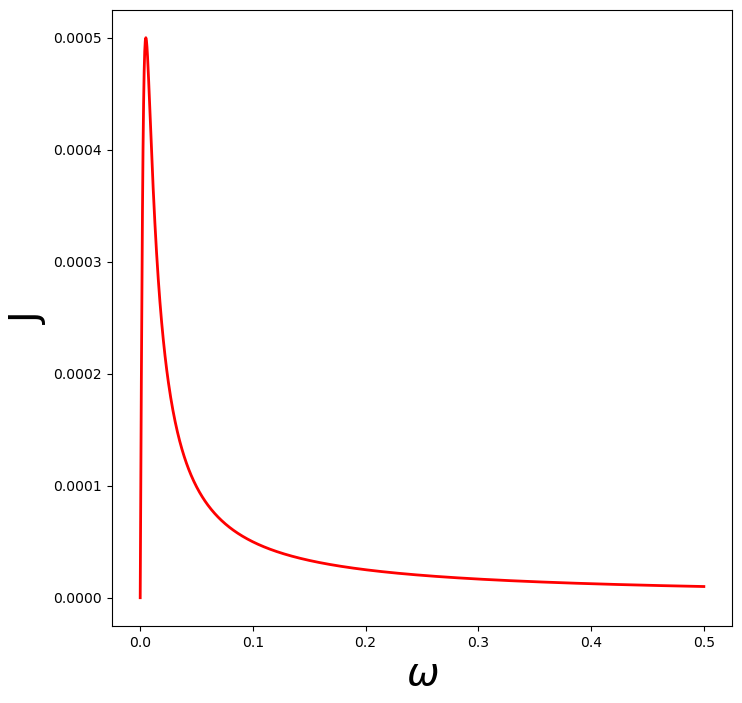

In [9]:
wlist = np.linspace(0, 0.5, 1000)
J = dl_spectrum(wlist, lam, gamma)

fig, axes = plt.subplots(1, 1, figsize=(8, 8))
axes.plot(wlist, J, 'r', linewidth=2)
axes.set_xlabel(r'$\omega$', fontsize=28)
axes.set_ylabel(r'J', fontsize=28);

## Dynamic decoupling with fast and slow pulses

Now we are ready to explore dynamic decoupling from the environment.

First we will drive the system with fast, large amplitude pulses. Then we will drive the system with slower, smaller amplitude pulses. The faster pulses decoupling the system more effectively and retain the coherence longer, but the slower pulses help too.

Let's start by simulating the fast pulses:

In [10]:
# Fast driving (quick, large amplitude pulses)

tlist = np.linspace(0, 400, 1000)

# start with a superposition so there is something to dephase!
rho0 = (basis(2, 1) + basis(2, 0)).unit()
rho0 = ket2dm(rho0)

# without pulses
hsolver = HEOMSolver(H_sys, bath, NC, options=options)
outputnoDD = hsolver.run(rho0, tlist)

# with pulses
drive_fast = drive(amplitude=0.5, delay=20, integral=np.pi / 2)
H_d = qutip.QobjEvo([H_sys, [H_drive, drive_fast]])

hsolver = HEOMSolver(H_d, bath, NC, options=options)
outputDD = hsolver.run(rho0, tlist)

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:02

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:02

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:02

 [          1%           ] Elapsed 0.03s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.04s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.04s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.04s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.06s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.44s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.44s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.44s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.44s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.44s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.47s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.47s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.47s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.47s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.47s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.60s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.60s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.60s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.60s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.60s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.61s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.61s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.61s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.61s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.61s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.62s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.62s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.62s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.62s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.62s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.62s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.63s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.63s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.63s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.63s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.63s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.64s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.64s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.64s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.64s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.64s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.65s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.65s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.65s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.65s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.65s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.65s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.66s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.66s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.66s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.66s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.66s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.67s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.67s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.67s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.67s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.67s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.68s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.68s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.68s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.68s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.68s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.68s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.69s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.69s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.69s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.69s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.70s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.70s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.70s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.70s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.70s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.70s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.71s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.71s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.71s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.71s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.71s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.72s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.72s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.72s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.72s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.72s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.72s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.73s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.73s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.73s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.73s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.73s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.74s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.74s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.74s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.74s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.74s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.75s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.75s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.75s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.75s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.75s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.75s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.76s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.76s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.76s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.76s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.76s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.77s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.77s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.77s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.77s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.77s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.78s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.78s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.78s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.78s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.78s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.78s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.79s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.79s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.79s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.79s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.79s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.80s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.80s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.80s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.80s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.80s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.81s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.81s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.81s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.81s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.81s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.81s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.82s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.82s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.82s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.82s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.82s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.83s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.83s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.83s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.83s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.83s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.84s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.84s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.84s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.84s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.85s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.85s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.85s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.85s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.85s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.86s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.86s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.86s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 0.86s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 0.86s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 0.87s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 0.87s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 0.87s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 0.87s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 0.87s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 0.88s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 0.88s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 0.88s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.89s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 0.89s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 0.89s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 0.89s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 0.90s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 0.90s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.57s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.57s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.57s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.57s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.57s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.58s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.58s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.58s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.58s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.58s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.59s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.59s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.59s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.59s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.59s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.59s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.60s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.60s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.60s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.60s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.60s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.61s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.61s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.61s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.61s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.61s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.62s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.62s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.62s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.62s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.62s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.62s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.63s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.63s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.63s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.63s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.63s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.64s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.64s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.64s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.64s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.64s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.65s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.65s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.65s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.65s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.65s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.65s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.66s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.66s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.66s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.66s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.66s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.67s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.67s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.67s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.67s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.67s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.68s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.68s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.68s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.68s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.68s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.69s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.69s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.69s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.69s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.69s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.69s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.70s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.70s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.70s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.70s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.70s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.71s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.71s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.71s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.71s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.71s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.72s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.72s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.72s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.72s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.72s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.73s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.73s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.73s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.73s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.73s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.73s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.74s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.74s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.74s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.74s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.74s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.75s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.75s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.75s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.75s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.75s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.76s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.76s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.76s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.76s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.76s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.77s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.77s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.77s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.77s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.77s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.77s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.78s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.78s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.78s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.78s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.78s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.79s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.79s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.79s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.79s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.79s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.80s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.80s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.80s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.80s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.80s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.81s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.81s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.81s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.81s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.81s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.82s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.82s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.82s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.82s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.82s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.83s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.83s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.83s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.83s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.83s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.84s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.84s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.84s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.84s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.84s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.85s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.85s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.85s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.85s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.85s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.86s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.86s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.86s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.86s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.87s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.87s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.87s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.87s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.87s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.88s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.88s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.88s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.88s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.88s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.89s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.89s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.89s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.89s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.89s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.90s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.90s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.90s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.90s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.90s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.91s / Remaining 00:00:00:00

 Total run time:   1.91s


 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:02

 [          1%           ] Elapsed 0.04s / Remaining 00:00:00:04

 [          1%           ] Elapsed 0.04s / Remaining 00:00:00:04

 [          1%           ] Elapsed 0.05s / Remaining 00:00:00:04

 [          1%           ] Elapsed 0.05s / Remaining 00:00:00:05

 [          1%           ] Elapsed 0.05s / Remaining 00:00:00:05

 [          1%           ] Elapsed 0.06s / Remaining 00:00:00:05

 [          1%           ] Elapsed 0.06s / Remaining 00:00:00:05

 [          2%           ] Elapsed 0.06s / Remaining 00:00:00:03

 [          2%           ] Elapsed 0.07s / Remaining 00:00:00:03

 [          2%           ] Elapsed 0.07s / Remaining 00:00:00:03

 [          2%           ] Elapsed 0.07s / Remaining 00:00:00:03

 [          2%           ] Elapsed 0.08s / Remaining 00:00:00:03

 [          2%           ] Elapsed 0.08s / Remaining 00:00:00:03

 [          2%           ] Elapsed 0.08s / Remaining 00:00:00:04

 [          2%           ] Elapsed 0.09s / Remaining 00:00:00:04

 [          2%           ] Elapsed 0.09s / Remaining 00:00:00:04

 [          2%           ] Elapsed 0.09s / Remaining 00:00:00:04

 [*         3%           ] Elapsed 0.09s / Remaining 00:00:00:03

 [*         3%           ] Elapsed 0.10s / Remaining 00:00:00:03

 [*         3%           ] Elapsed 0.10s / Remaining 00:00:00:03

 [*         3%           ] Elapsed 0.10s / Remaining 00:00:00:03

 [*         3%           ] Elapsed 0.11s / Remaining 00:00:00:03

 [*         3%           ] Elapsed 0.11s / Remaining 00:00:00:03

 [*         3%           ] Elapsed 0.11s / Remaining 00:00:00:03

 [*         3%           ] Elapsed 0.12s / Remaining 00:00:00:03

 [*         3%           ] Elapsed 0.12s / Remaining 00:00:00:03

 [*         3%           ] Elapsed 0.12s / Remaining 00:00:00:03

 [*         4%           ] Elapsed 0.13s / Remaining 00:00:00:03

 [*         4%           ] Elapsed 0.13s / Remaining 00:00:00:03

 [*         4%           ] Elapsed 0.13s / Remaining 00:00:00:03

 [*         4%           ] Elapsed 0.14s / Remaining 00:00:00:03

 [*         4%           ] Elapsed 0.14s / Remaining 00:00:00:03

 [*         4%           ] Elapsed 0.14s / Remaining 00:00:00:03

 [*         4%           ] Elapsed 0.15s / Remaining 00:00:00:03

 [*         4%           ] Elapsed 0.15s / Remaining 00:00:00:03

 [*         4%           ] Elapsed 0.15s / Remaining 00:00:00:03

 [*         4%           ] Elapsed 0.15s / Remaining 00:00:00:03

 [*         5%           ] Elapsed 0.16s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.16s / Remaining 00:00:00:03

 [*         5%           ] Elapsed 0.16s / Remaining 00:00:00:03

 [*         5%           ] Elapsed 0.17s / Remaining 00:00:00:03

 [*         5%           ] Elapsed 0.17s / Remaining 00:00:00:03

 [*         5%           ] Elapsed 0.17s / Remaining 00:00:00:03

 [*         5%           ] Elapsed 0.18s / Remaining 00:00:00:03

 [*         5%           ] Elapsed 0.18s / Remaining 00:00:00:03

 [*         5%           ] Elapsed 0.18s / Remaining 00:00:00:03

 [*         5%           ] Elapsed 0.19s / Remaining 00:00:00:03

 [*         6%           ] Elapsed 0.19s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.19s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.19s / Remaining 00:00:00:03

 [*         6%           ] Elapsed 0.22s / Remaining 00:00:00:03

 [*         6%           ] Elapsed 0.22s / Remaining 00:00:00:03

 [*         6%           ] Elapsed 0.22s / Remaining 00:00:00:03

 [*         6%           ] Elapsed 0.23s / Remaining 00:00:00:03

 [*         6%           ] Elapsed 0.23s / Remaining 00:00:00:03

 [*         6%           ] Elapsed 0.23s / Remaining 00:00:00:03

 [*         6%           ] Elapsed 0.23s / Remaining 00:00:00:03

 [**        7%           ] Elapsed 0.24s / Remaining 00:00:00:03

 [**        7%           ] Elapsed 0.26s / Remaining 00:00:00:03

 [**        7%           ] Elapsed 0.26s / Remaining 00:00:00:03

 [**        7%           ] Elapsed 0.26s / Remaining 00:00:00:03

 [**        7%           ] Elapsed 0.27s / Remaining 00:00:00:03

 [**        7%           ] Elapsed 0.27s / Remaining 00:00:00:03

 [**        7%           ] Elapsed 0.27s / Remaining 00:00:00:03

 [**        7%           ] Elapsed 0.28s / Remaining 00:00:00:03

 [**        7%           ] Elapsed 0.28s / Remaining 00:00:00:03

 [**        7%           ] Elapsed 0.28s / Remaining 00:00:00:03

 [**        8%           ] Elapsed 0.28s / Remaining 00:00:00:03

 [**        8%           ] Elapsed 0.29s / Remaining 00:00:00:03

 [**        8%           ] Elapsed 0.29s / Remaining 00:00:00:03

 [**        8%           ] Elapsed 0.29s / Remaining 00:00:00:03

 [**        8%           ] Elapsed 0.30s / Remaining 00:00:00:03

 [**        8%           ] Elapsed 0.30s / Remaining 00:00:00:03

 [**        8%           ] Elapsed 0.30s / Remaining 00:00:00:03

 [**        8%           ] Elapsed 0.31s / Remaining 00:00:00:03

 [**        8%           ] Elapsed 0.31s / Remaining 00:00:00:03

 [**        8%           ] Elapsed 0.31s / Remaining 00:00:00:03

 [**        9%           ] Elapsed 0.32s / Remaining 00:00:00:03

 [**        9%           ] Elapsed 0.32s / Remaining 00:00:00:03

 [**        9%           ] Elapsed 0.32s / Remaining 00:00:00:03

 [**        9%           ] Elapsed 0.32s / Remaining 00:00:00:03

 [**        9%           ] Elapsed 0.33s / Remaining 00:00:00:03

 [**        9%           ] Elapsed 0.33s / Remaining 00:00:00:03

 [**        9%           ] Elapsed 0.33s / Remaining 00:00:00:03

 [**        9%           ] Elapsed 0.34s / Remaining 00:00:00:03

 [**        9%           ] Elapsed 0.34s / Remaining 00:00:00:03

 [**        9%           ] Elapsed 0.34s / Remaining 00:00:00:03

 [**       10%           ] Elapsed 0.35s / Remaining 00:00:00:03

 [**       10%           ] Elapsed 0.35s / Remaining 00:00:00:03

 [**       10%           ] Elapsed 0.35s / Remaining 00:00:00:03

 [**       10%           ] Elapsed 0.36s / Remaining 00:00:00:03

 [**       10%           ] Elapsed 0.36s / Remaining 00:00:00:03

 [**       10%           ] Elapsed 0.36s / Remaining 00:00:00:03

 [**       10%           ] Elapsed 0.37s / Remaining 00:00:00:03

 [**       10%           ] Elapsed 0.37s / Remaining 00:00:00:03

 [**       10%           ] Elapsed 0.37s / Remaining 00:00:00:03

 [**       10%           ] Elapsed 0.38s / Remaining 00:00:00:03

 [***      11%           ] Elapsed 0.38s / Remaining 00:00:00:03

 [***      11%           ] Elapsed 0.38s / Remaining 00:00:00:03

 [***      11%           ] Elapsed 0.38s / Remaining 00:00:00:03

 [***      11%           ] Elapsed 0.39s / Remaining 00:00:00:03

 [***      11%           ] Elapsed 0.39s / Remaining 00:00:00:03

 [***      11%           ] Elapsed 0.39s / Remaining 00:00:00:03

 [***      11%           ] Elapsed 0.40s / Remaining 00:00:00:03

 [***      11%           ] Elapsed 0.40s / Remaining 00:00:00:03

 [***      11%           ] Elapsed 0.40s / Remaining 00:00:00:03

 [***      11%           ] Elapsed 0.41s / Remaining 00:00:00:03

 [***      12%           ] Elapsed 0.41s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.43s / Remaining 00:00:00:03

 [***      12%           ] Elapsed 0.43s / Remaining 00:00:00:03

 [***      12%           ] Elapsed 0.43s / Remaining 00:00:00:03

 [***      12%           ] Elapsed 0.44s / Remaining 00:00:00:03

 [***      12%           ] Elapsed 0.44s / Remaining 00:00:00:03

 [***      12%           ] Elapsed 0.44s / Remaining 00:00:00:03

 [***      12%           ] Elapsed 0.45s / Remaining 00:00:00:03

 [***      12%           ] Elapsed 0.45s / Remaining 00:00:00:03

 [***      12%           ] Elapsed 0.47s / Remaining 00:00:00:03

 [***      13%           ] Elapsed 0.47s / Remaining 00:00:00:03

 [***      13%           ] Elapsed 0.48s / Remaining 00:00:00:03

 [***      13%           ] Elapsed 0.48s / Remaining 00:00:00:03

 [***      13%           ] Elapsed 0.48s / Remaining 00:00:00:03

 [***      13%           ] Elapsed 0.48s / Remaining 00:00:00:03

 [***      13%           ] Elapsed 0.49s / Remaining 00:00:00:03

 [***      13%           ] Elapsed 0.49s / Remaining 00:00:00:03

 [***      13%           ] Elapsed 0.49s / Remaining 00:00:00:03

 [***      13%           ] Elapsed 0.50s / Remaining 00:00:00:03

 [***      13%           ] Elapsed 0.50s / Remaining 00:00:00:03

 [***      14%           ] Elapsed 0.50s / Remaining 00:00:00:03

 [***      14%           ] Elapsed 0.50s / Remaining 00:00:00:03

 [***      14%           ] Elapsed 0.51s / Remaining 00:00:00:03

 [***      14%           ] Elapsed 0.51s / Remaining 00:00:00:03

 [***      14%           ] Elapsed 0.51s / Remaining 00:00:00:03

 [***      14%           ] Elapsed 0.52s / Remaining 00:00:00:03

 [***      14%           ] Elapsed 0.52s / Remaining 00:00:00:03

 [***      14%           ] Elapsed 0.52s / Remaining 00:00:00:03

 [***      14%           ] Elapsed 0.53s / Remaining 00:00:00:03

 [***      14%           ] Elapsed 0.53s / Remaining 00:00:00:03

 [***      15%           ] Elapsed 0.53s / Remaining 00:00:00:03

 [***      15%           ] Elapsed 0.54s / Remaining 00:00:00:03

 [***      15%           ] Elapsed 0.54s / Remaining 00:00:00:03

 [***      15%           ] Elapsed 0.54s / Remaining 00:00:00:03

 [***      15%           ] Elapsed 0.55s / Remaining 00:00:00:03

 [***      15%           ] Elapsed 0.55s / Remaining 00:00:00:03

 [***      15%           ] Elapsed 0.55s / Remaining 00:00:00:03

 [***      15%           ] Elapsed 0.56s / Remaining 00:00:00:03

 [***      15%           ] Elapsed 0.56s / Remaining 00:00:00:03

 [***      15%           ] Elapsed 0.56s / Remaining 00:00:00:03

 [****     16%           ] Elapsed 0.56s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.57s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.57s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.57s / Remaining 00:00:00:03

 [****     16%           ] Elapsed 0.58s / Remaining 00:00:00:03

 [****     16%           ] Elapsed 0.58s / Remaining 00:00:00:03

 [****     16%           ] Elapsed 0.58s / Remaining 00:00:00:03

 [****     16%           ] Elapsed 0.59s / Remaining 00:00:00:03

 [****     16%           ] Elapsed 0.59s / Remaining 00:00:00:03

 [****     16%           ] Elapsed 0.59s / Remaining 00:00:00:03

 [****     17%           ] Elapsed 0.60s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.60s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.60s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.60s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.61s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.61s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.61s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.62s / Remaining 00:00:00:03

 [****     17%           ] Elapsed 0.62s / Remaining 00:00:00:03

 [****     17%           ] Elapsed 0.64s / Remaining 00:00:00:03

 [****     18%           ] Elapsed 0.64s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.65s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.65s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.65s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.66s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.66s / Remaining 00:00:00:03

 [****     18%           ] Elapsed 0.66s / Remaining 00:00:00:03

 [****     18%           ] Elapsed 0.69s / Remaining 00:00:00:03

 [****     18%           ] Elapsed 0.69s / Remaining 00:00:00:03

 [****     18%           ] Elapsed 0.69s / Remaining 00:00:00:03

 [****     19%           ] Elapsed 0.70s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.70s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.70s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.70s / Remaining 00:00:00:03

 [****     19%           ] Elapsed 0.71s / Remaining 00:00:00:03

 [****     19%           ] Elapsed 0.71s / Remaining 00:00:00:03

 [****     19%           ] Elapsed 0.71s / Remaining 00:00:00:03

 [****     19%           ] Elapsed 0.72s / Remaining 00:00:00:03

 [****     19%           ] Elapsed 0.72s / Remaining 00:00:00:03

 [****     19%           ] Elapsed 0.72s / Remaining 00:00:00:03

 [*****    20%           ] Elapsed 0.73s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.73s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.73s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.73s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.74s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.74s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.74s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.75s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.75s / Remaining 00:00:00:03

 [*****    20%           ] Elapsed 0.75s / Remaining 00:00:00:03

 [*****    21%           ] Elapsed 0.76s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.76s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.76s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.77s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.77s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.77s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.78s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.78s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.78s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.78s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.79s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.79s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.79s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.80s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.80s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.80s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.80s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.81s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.81s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.81s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.82s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.82s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.82s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.82s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.83s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.83s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.83s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.86s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.86s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.86s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.86s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.87s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.87s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.87s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.88s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.90s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.90s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.90s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.91s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.91s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.91s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.92s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.92s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.92s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.93s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.93s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.93s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.93s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.94s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.94s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.94s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.95s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.95s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.95s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.96s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.96s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.96s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.97s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.97s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.97s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.97s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.98s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.98s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.98s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.99s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.99s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.99s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 1.00s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 1.00s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 1.00s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 1.01s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 1.01s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 1.01s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 1.02s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 1.02s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 1.02s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 1.02s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 1.03s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 1.03s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 1.03s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 1.04s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 1.04s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 1.04s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 1.05s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 1.07s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 1.07s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 1.08s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 1.08s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 1.08s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 1.09s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 1.09s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 1.09s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 1.12s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 1.12s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 1.12s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 1.12s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 1.13s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 1.13s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 1.13s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 1.14s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 1.14s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 1.14s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 1.15s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 1.15s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 1.15s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 1.15s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 1.16s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 1.16s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 1.16s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 1.17s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.17s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.17s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.18s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.18s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.18s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.19s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.19s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.19s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.19s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.20s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.20s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.20s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.21s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.21s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.21s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.21s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.22s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.22s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.22s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.23s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.23s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.23s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.24s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.24s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.24s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.24s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.25s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.25s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.25s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.26s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.26s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.26s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.28s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.28s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.29s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.29s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.29s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.30s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.30s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.30s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.32s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.32s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.33s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.33s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.33s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.33s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.34s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.34s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.34s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.35s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.35s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.35s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.36s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.36s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.36s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.37s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.37s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.37s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.37s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.38s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.38s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.38s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.39s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.39s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.39s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.40s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.40s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.40s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.41s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.41s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.41s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.41s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.42s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.42s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.42s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.43s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.43s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.43s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.44s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.44s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.44s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.44s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.45s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.45s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.45s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.46s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.46s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.46s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.46s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.47s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.49s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.49s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.50s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.50s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.50s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.51s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.51s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.51s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.53s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.54s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.54s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.54s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.55s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.55s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.55s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.55s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.56s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.56s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.56s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.57s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.57s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.57s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.57s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.58s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.58s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.58s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.59s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.59s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.59s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.59s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 1.60s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 1.60s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 1.60s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 1.61s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 1.61s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 1.61s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 1.61s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 1.62s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 1.62s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 1.62s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 1.63s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.63s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.63s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.64s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 1.64s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 1.65s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 1.65s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 1.66s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 1.66s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 1.66s / Remaining 00:00:00:02

 [*********46%           ] Elapsed 1.67s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.67s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.67s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.68s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.68s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.68s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.69s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.69s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.71s / Remaining 00:00:00:02

 [*********46%           ] Elapsed 1.72s / Remaining 00:00:00:02

 [*********47%           ] Elapsed 1.72s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.72s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.72s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.73s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.73s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.73s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.75s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.76s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.76s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.76s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.77s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.77s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.77s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.78s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.78s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.78s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.78s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.79s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.79s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.79s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.80s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.80s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.80s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.80s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.81s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.81s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.81s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.82s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.82s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.82s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.82s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.83s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.83s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.83s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.84s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.84s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.84s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.84s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.85s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.85s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.85s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.85s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.86s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.86s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.86s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.87s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.87s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.87s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.87s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.88s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.88s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.88s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.89s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.89s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.89s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.89s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.91s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.92s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.92s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.92s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.92s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.93s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.93s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.93s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.95s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.96s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.96s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.96s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.97s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.97s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.97s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.97s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.98s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.98s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.98s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 2.00s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 2.00s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 2.00s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 2.01s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 2.01s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 2.01s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 2.01s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 2.02s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 2.02s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 2.02s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 2.03s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 2.03s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 2.03s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 2.03s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 2.04s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 2.04s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 2.04s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 2.05s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 2.05s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 2.05s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 2.05s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.06s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.06s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.06s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.07s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.07s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.07s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.07s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.08s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.08s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.08s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.08s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.09s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.09s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.12s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.12s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.12s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.13s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.13s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.13s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.13s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.14s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.16s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.16s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.16s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.17s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.17s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.17s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.17s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.18s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.18s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.18s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.19s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.19s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.19s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.19s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.20s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.20s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.20s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.21s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.21s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.21s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.21s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.22s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.22s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.22s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.23s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.23s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.23s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.23s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.24s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.24s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.24s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.24s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.25s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.25s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.25s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.26s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.26s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.26s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.26s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.27s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.27s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.27s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.28s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.28s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.28s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.28s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.29s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.29s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.29s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.30s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.32s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.32s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.32s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.33s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.33s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.33s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.34s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.34s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.36s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.36s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.36s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.37s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.37s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.37s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.38s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.38s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.38s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.38s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.39s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.39s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.39s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.39s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.40s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.40s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.40s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.41s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.41s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.41s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.41s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.42s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.42s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.42s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.43s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.43s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.43s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.44s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.44s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.44s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.44s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.45s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.45s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.46s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.46s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.46s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.46s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.47s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.47s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.47s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.48s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.48s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.48s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.49s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.49s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.49s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.49s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.50s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.50s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.50s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.52s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.52s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.53s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.53s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.53s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.54s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.54s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.54s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.56s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.57s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.57s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 2.57s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 2.57s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 2.58s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 2.58s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 2.58s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 2.59s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 2.59s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 2.59s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 2.60s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 2.60s / Remaining 00:00:00:01

 [*********72%*****      ] Elapsed 2.60s / Remaining 00:00:00:01

 [*********72%*****      ] Elapsed 2.61s / Remaining 00:00:00:01

 [*********72%*****      ] Elapsed 2.61s / Remaining 00:00:00:01

 [*********72%*****      ] Elapsed 2.61s / Remaining 00:00:00:01

 [*********72%*****      ] Elapsed 2.61s / Remaining 00:00:00:01

 [*********72%*****      ] Elapsed 2.62s / Remaining 00:00:00:01

 [*********72%*****      ] Elapsed 2.62s / Remaining 00:00:00:01

 [*********72%*****      ] Elapsed 2.62s / Remaining 00:00:00:01

 [*********72%*****      ] Elapsed 2.63s / Remaining 00:00:00:01

 [*********72%*****      ] Elapsed 2.63s / Remaining 00:00:00:01

 [*********73%*****      ] Elapsed 2.63s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.64s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.64s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.64s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.64s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.65s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.65s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.65s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.66s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.66s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.66s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.66s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.67s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.67s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.67s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.68s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.68s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.68s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.69s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.69s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.69s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.69s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.70s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.70s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.70s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.71s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.71s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.73s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.73s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.73s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.74s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.74s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.74s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.75s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.75s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.77s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.77s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.78s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.78s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.78s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.79s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.79s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.79s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.80s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.80s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.80s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.81s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.81s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.81s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.81s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.82s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.82s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.82s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.83s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.83s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.83s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.84s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.84s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.84s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.84s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.85s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.85s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.85s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.86s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.86s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.86s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.87s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.87s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.87s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.87s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.88s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.88s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.88s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.89s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.89s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.89s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.90s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.90s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.90s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.90s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.91s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.91s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.91s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.92s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.92s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.94s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.94s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.94s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.95s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.95s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.95s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.95s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.97s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.98s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.98s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.98s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.99s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.99s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.99s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 3.00s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 3.00s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 3.00s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 3.01s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 3.01s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 3.01s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 3.02s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 3.02s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 3.02s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 3.03s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 3.03s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 3.03s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 3.03s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 3.04s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 3.04s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 3.04s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 3.05s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 3.05s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 3.05s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 3.06s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 3.06s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 3.06s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 3.06s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 3.07s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 3.07s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 3.07s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 3.08s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 3.08s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 3.08s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 3.09s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 3.09s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 3.09s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 3.10s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 3.10s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 3.10s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 3.10s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 3.11s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 3.11s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 3.11s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 3.12s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 3.12s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 3.12s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 3.13s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 3.14s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 3.15s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 3.15s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 3.15s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 3.16s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 3.16s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 3.16s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 3.17s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 3.19s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 3.19s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 3.19s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 3.20s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 3.20s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 3.20s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 3.21s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 3.21s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 3.21s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 3.22s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 3.22s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 3.22s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 3.22s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 3.23s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 3.23s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 3.23s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 3.24s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 3.24s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 3.24s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 3.25s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 3.25s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 3.25s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 3.26s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 3.26s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 3.26s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 3.26s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 3.27s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 3.27s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 3.27s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 3.28s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 3.28s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 3.28s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 3.29s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 3.29s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 3.29s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 3.29s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 3.30s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 3.30s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 3.30s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 3.31s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 3.31s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 3.31s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 3.32s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 3.32s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 3.32s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 3.32s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 3.33s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 3.33s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 3.33s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 3.34s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 3.36s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 3.36s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 3.37s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 3.37s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 3.37s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 3.38s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 3.38s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 3.38s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 3.40s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 3.41s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.41s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.41s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.41s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.42s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.42s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.42s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.43s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.43s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.43s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.43s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.44s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.44s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.44s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.45s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.45s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.45s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.45s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.46s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.46s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.46s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.47s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.47s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.47s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.47s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.48s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.48s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.48s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.49s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.49s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.49s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.49s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.50s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.50s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.50s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.51s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.51s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.51s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.51s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.52s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.52s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.52s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.52s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.53s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.53s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.53s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.54s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.56s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.56s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.56s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.57s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.57s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.57s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.57s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.58s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.60s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.60s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.60s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.61s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.61s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.61s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.62s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.62s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.62s / Remaining 00:00:00:00

 Total run time:   3.62s


And now the longer slower pulses:

In [11]:
# Slow driving (longer, small amplitude pulses)

# without pulses
hsolver = HEOMSolver(H_sys, bath, NC, options=options)
outputnoDDslow = hsolver.run(rho0, tlist)

# with pulses
drive_slow = drive(amplitude=0.01, delay=20, integral=np.pi/2)
H_d = QobjEvo([H_sys, [H_drive, drive_slow]])

hsolver = HEOMSolver(H_d, bath, NC, options=options)
outputDDslow = hsolver.run(rho0, tlist)

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:02

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:02

 [          1%           ] Elapsed 0.03s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.04s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.04s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.06s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.42s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.43s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.44s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.44s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.44s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.44s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.44s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.45s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.46s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.47s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.47s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.47s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.47s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.48s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.49s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.50s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.51s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.52s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.53s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.54s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.55s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.56s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.57s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.58s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.59s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.60s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.60s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.60s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.60s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.60s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.61s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.61s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.61s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.61s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.61s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.62s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.62s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.62s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.62s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.62s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.63s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.63s / Remaining 00:00:00:01

 [*******  31%           ] Elapsed 0.63s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.63s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.63s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.64s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.64s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.64s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.64s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.65s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.65s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.65s / Remaining 00:00:00:01

 [*******  32%           ] Elapsed 0.65s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.65s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.66s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.66s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.66s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.66s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.66s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.67s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.67s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.67s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.67s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.67s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.68s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.68s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.68s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.68s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.68s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.69s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.69s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.69s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 0.69s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.69s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.70s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.70s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.70s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.70s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.70s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.71s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.71s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.71s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 0.71s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.72s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.72s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.72s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.72s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.72s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.73s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.73s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.73s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.73s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 0.73s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.74s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.74s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.74s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.74s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.74s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.75s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.75s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.75s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.75s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 0.75s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.76s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.76s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.76s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.76s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.76s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.77s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.77s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.77s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.77s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 0.78s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.78s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.78s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.78s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.78s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.79s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.79s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.79s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.79s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.79s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 0.80s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.80s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.80s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.80s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.80s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.81s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.81s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.81s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.81s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.81s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 0.82s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.82s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.82s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.82s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.83s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.83s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.83s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.83s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.83s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.84s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 0.84s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.84s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.84s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.84s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.85s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.85s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.85s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.85s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.86s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.86s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 0.86s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.86s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.86s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.86s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.87s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.87s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.87s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.87s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.87s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.88s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 0.88s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.88s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.88s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.88s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.89s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.89s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.89s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.89s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.89s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.90s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 0.90s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.90s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.90s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.90s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.91s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.91s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.91s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.91s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.91s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.92s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 0.92s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 0.92s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 0.92s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 0.92s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 0.93s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 0.93s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 0.93s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 0.93s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 0.94s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 0.94s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 0.94s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 0.94s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 0.94s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 0.95s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 0.95s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 0.95s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 0.95s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 0.95s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 0.96s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 0.96s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 0.96s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 0.96s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 0.96s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 0.97s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 0.97s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 0.97s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 0.97s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 0.97s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 0.98s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 0.98s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 0.98s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 0.98s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 0.98s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 0.99s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 0.99s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 0.99s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 0.99s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 0.99s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.00s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.00s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.00s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.00s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.00s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.01s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.01s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.01s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.01s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.01s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.02s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.02s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.02s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.37s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.38s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.39s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.40s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.41s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.42s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.43s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.44s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.45s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.46s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.47s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.48s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.49s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.50s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.51s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.52s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.53s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.54s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.55s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.57s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.57s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.57s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.57s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.57s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.58s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.58s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.58s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.58s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.58s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.59s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.59s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.59s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.59s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.59s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.60s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.60s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.60s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.60s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.60s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.60s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.61s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.61s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.61s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.61s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.61s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.62s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.62s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.62s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.62s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.62s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.63s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.63s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.63s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.63s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.63s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.63s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.64s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.64s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.64s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.64s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.64s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.65s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.65s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.65s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.65s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.65s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.65s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.66s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.66s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.66s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.66s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.66s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.67s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.67s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.67s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.67s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.67s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.69s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.69s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.69s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.69s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.69s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.70s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.70s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.70s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.70s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.70s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.71s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.71s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.71s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.71s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.71s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.71s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.72s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.72s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.72s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.72s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.72s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.73s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.73s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.73s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.73s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.73s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.73s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.74s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.74s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.74s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.74s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.74s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.75s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.75s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.75s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.75s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.75s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.76s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.76s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.76s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.76s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.76s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.76s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.77s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.77s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.77s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.77s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.77s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.78s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.78s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.78s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.78s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.78s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.79s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.79s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.79s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.79s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.79s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.79s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.80s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.80s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.80s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.80s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.80s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.81s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.81s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.81s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.81s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.81s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.82s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.82s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.82s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.82s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.82s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.82s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.83s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.83s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.83s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.83s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.83s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.84s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.84s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.84s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.84s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.84s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.85s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.85s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.85s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.85s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.85s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.85s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.86s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.86s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.86s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.86s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.86s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.87s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.87s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.87s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.87s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.87s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.87s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.88s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.88s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.88s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.88s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.88s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.89s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.89s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.89s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.89s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.89s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.90s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.90s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.90s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.90s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.90s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.90s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.91s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.91s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.91s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.91s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.91s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.92s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.92s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.92s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.92s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.92s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.93s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.93s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.93s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.93s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.93s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.93s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.94s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.94s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.94s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.94s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.94s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.95s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.95s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.95s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.95s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.95s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.95s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.96s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.96s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.96s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.96s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.96s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.97s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.97s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.97s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.97s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.97s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.98s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.98s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.98s / Remaining 00:00:00:00

 Total run time:   1.98s


 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:02

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:02

 [          1%           ] Elapsed 0.03s / Remaining 00:00:00:02

 [          1%           ] Elapsed 0.03s / Remaining 00:00:00:02

 [          1%           ] Elapsed 0.03s / Remaining 00:00:00:03

 [          1%           ] Elapsed 0.04s / Remaining 00:00:00:03

 [          1%           ] Elapsed 0.04s / Remaining 00:00:00:03

 [          1%           ] Elapsed 0.04s / Remaining 00:00:00:04

 [          2%           ] Elapsed 0.05s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.05s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.05s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.05s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.06s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.06s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.06s / Remaining 00:00:00:03

 [          2%           ] Elapsed 0.07s / Remaining 00:00:00:03

 [          2%           ] Elapsed 0.07s / Remaining 00:00:00:03

 [          2%           ] Elapsed 0.07s / Remaining 00:00:00:03

 [*         3%           ] Elapsed 0.08s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.08s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.08s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.09s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.09s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.09s / Remaining 00:00:00:02

 [*         3%           ] Elapsed 0.10s / Remaining 00:00:00:03

 [*         3%           ] Elapsed 0.10s / Remaining 00:00:00:03

 [*         3%           ] Elapsed 0.10s / Remaining 00:00:00:03

 [*         3%           ] Elapsed 0.10s / Remaining 00:00:00:03

 [*         4%           ] Elapsed 0.11s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.11s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.11s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.12s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.12s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.12s / Remaining 00:00:00:02

 [*         4%           ] Elapsed 0.13s / Remaining 00:00:00:03

 [*         4%           ] Elapsed 0.13s / Remaining 00:00:00:03

 [*         4%           ] Elapsed 0.13s / Remaining 00:00:00:03

 [*         4%           ] Elapsed 0.14s / Remaining 00:00:00:03

 [*         5%           ] Elapsed 0.14s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.14s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.14s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.15s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.15s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.15s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.16s / Remaining 00:00:00:02

 [*         5%           ] Elapsed 0.16s / Remaining 00:00:00:03

 [*         5%           ] Elapsed 0.16s / Remaining 00:00:00:03

 [*         5%           ] Elapsed 0.17s / Remaining 00:00:00:03

 [*         6%           ] Elapsed 0.17s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.17s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.18s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.18s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.18s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.19s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.19s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.19s / Remaining 00:00:00:02

 [*         6%           ] Elapsed 0.19s / Remaining 00:00:00:03

 [*         6%           ] Elapsed 0.20s / Remaining 00:00:00:03

 [**        7%           ] Elapsed 0.20s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.20s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.21s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.21s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.21s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.21s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.22s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.22s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.22s / Remaining 00:00:00:02

 [**        7%           ] Elapsed 0.23s / Remaining 00:00:00:03

 [**        8%           ] Elapsed 0.23s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.23s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.24s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.24s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.24s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.24s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.25s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.25s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.25s / Remaining 00:00:00:02

 [**        8%           ] Elapsed 0.26s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.26s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.26s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.27s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.27s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.27s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.27s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.28s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.28s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.28s / Remaining 00:00:00:02

 [**        9%           ] Elapsed 0.29s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.29s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.29s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.29s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.30s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.30s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.30s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.31s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.31s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.31s / Remaining 00:00:00:02

 [**       10%           ] Elapsed 0.31s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.32s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.32s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.32s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.33s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.33s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.33s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.33s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.34s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.34s / Remaining 00:00:00:02

 [***      11%           ] Elapsed 0.34s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.35s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.35s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.35s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.36s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.36s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.36s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.36s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.37s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.37s / Remaining 00:00:00:02

 [***      12%           ] Elapsed 0.37s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.38s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.38s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.38s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.38s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.39s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.39s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.39s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.40s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.40s / Remaining 00:00:00:02

 [***      13%           ] Elapsed 0.40s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.40s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.41s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.41s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.41s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.42s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.42s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.42s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.43s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.43s / Remaining 00:00:00:02

 [***      14%           ] Elapsed 0.43s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.43s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.44s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.44s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.44s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.45s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.45s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.45s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.45s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.46s / Remaining 00:00:00:02

 [***      15%           ] Elapsed 0.46s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.46s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.47s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.47s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.47s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.47s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.48s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.48s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.48s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.49s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.49s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.49s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.49s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.50s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.50s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.50s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.51s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.51s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.51s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.51s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.52s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.52s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.52s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.53s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.53s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.53s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.53s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.54s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.54s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.54s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.55s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.55s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.55s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.56s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.56s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.56s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.56s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.57s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.57s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.57s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.58s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.58s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.58s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.59s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.59s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.59s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.59s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.60s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.60s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.60s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.61s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.61s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.61s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.62s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.62s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.62s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.63s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.63s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.63s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.63s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.64s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.64s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.64s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.65s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.65s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.65s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.66s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.66s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.66s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.66s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.67s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.67s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.67s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.68s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.68s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.68s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.69s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.69s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.69s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.69s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.70s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.70s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.70s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.71s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.71s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.71s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.72s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.72s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.72s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.72s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.73s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.73s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.73s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.74s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.74s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.74s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.75s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.75s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.75s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.76s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.76s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.76s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.76s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.77s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.77s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.77s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.78s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.78s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.78s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.79s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.79s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.79s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.79s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.80s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.80s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.80s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.81s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.81s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.81s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.82s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.82s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.82s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.82s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.83s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.83s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.83s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.84s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.84s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.84s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.85s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.85s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.85s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.86s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.86s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.86s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.86s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.87s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.87s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.87s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.88s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.88s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.88s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.88s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.89s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.89s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.89s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.90s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.90s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.90s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.91s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.91s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.91s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.92s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.92s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.92s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.92s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.93s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.93s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.93s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.94s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.94s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.94s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.94s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.95s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.95s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.95s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.96s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.96s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.96s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.96s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.97s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 0.97s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.97s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.98s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.98s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.98s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.98s / Remaining 00:00:00:01

 [******** 33%           ] Elapsed 0.99s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 0.99s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 0.99s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 0.99s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.00s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 1.00s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 1.00s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 1.01s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 1.01s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 1.01s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 1.01s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 1.02s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 1.02s / Remaining 00:00:00:01

 [******** 34%           ] Elapsed 1.02s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 1.03s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 1.03s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 1.03s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 1.03s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 1.04s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 1.04s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 1.04s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 1.05s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 1.05s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 1.05s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.05s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.06s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.06s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.06s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.07s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.07s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.07s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.07s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.08s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.08s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.08s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.08s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.09s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.09s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.09s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.10s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.10s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.10s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.10s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.11s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.11s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.11s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.12s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.12s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.12s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.12s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.13s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.13s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.13s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.14s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.14s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.14s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.15s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.15s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.15s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.15s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.16s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.16s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.19s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.19s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.19s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.19s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.20s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.20s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.20s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.21s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.21s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.21s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.22s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.22s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.22s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.23s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.23s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.23s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.23s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.24s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.24s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.24s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.25s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.25s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.25s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.26s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.26s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.26s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.27s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.27s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.27s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.27s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.28s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.28s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.28s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.29s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.29s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.29s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.30s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.30s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.30s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.30s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.31s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.31s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.31s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.32s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.32s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.32s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.33s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.33s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.33s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.34s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.35s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.36s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.36s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.36s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.37s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.37s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.37s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.38s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.38s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.38s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.38s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.39s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.39s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.39s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.40s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.40s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.40s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.41s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.41s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.41s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.41s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.42s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.42s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.42s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.43s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.43s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.43s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.44s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.44s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.44s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.45s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.45s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.45s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.45s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.46s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.46s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.46s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.47s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.47s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.47s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.48s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.48s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.48s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.48s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.49s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.49s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.49s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.50s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.50s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.50s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.50s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.51s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.51s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.51s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.52s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.52s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.52s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.53s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.53s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.53s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.54s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.54s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.54s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.54s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.55s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.55s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.55s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.56s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.56s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.56s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.57s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.57s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.57s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.57s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.58s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.58s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.58s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.59s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.59s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.59s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.60s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.60s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.60s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.60s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.61s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.61s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.61s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.62s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.62s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.62s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.63s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.63s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.63s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.63s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.64s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.64s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.64s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.65s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.65s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.65s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.65s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.66s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.66s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.66s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.66s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.67s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.67s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.67s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.68s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.68s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.68s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.68s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.69s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.69s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.69s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.70s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.70s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.70s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.70s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.71s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.71s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.71s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.72s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.72s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.72s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.72s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.73s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.73s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.73s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.74s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.74s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.74s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.74s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.75s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.75s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.75s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.76s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.76s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.76s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.76s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.77s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.77s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.77s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.78s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.78s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.78s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.78s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.79s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.79s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.79s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.80s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.80s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.80s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.81s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.81s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.81s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.81s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.82s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.82s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.82s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.82s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.83s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.83s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.83s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.84s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.84s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.84s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.84s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.85s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.85s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.85s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.86s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.86s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.86s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.86s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.87s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.87s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.87s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.88s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.88s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.88s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.88s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.89s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.89s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.89s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.90s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.90s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.90s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.90s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.91s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.91s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.91s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.91s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.92s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.92s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.92s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.93s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.93s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.93s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.93s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.94s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.94s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 1.94s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 1.95s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 1.95s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 1.95s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 1.95s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 1.96s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 1.96s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 1.96s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 1.97s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 1.97s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 1.97s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 1.97s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 1.98s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 1.98s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 1.98s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.00s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.00s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 2.00s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 2.01s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 2.01s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 2.01s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 2.01s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 2.02s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 2.02s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 2.02s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 2.02s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 2.03s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 2.03s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 2.03s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 2.04s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 2.04s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 2.04s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 2.04s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 2.05s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 2.05s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 2.05s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.06s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.06s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.06s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.06s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.07s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.07s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.07s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.08s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.08s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 2.08s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.08s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.09s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.09s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.09s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.10s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.10s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.10s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.11s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.11s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 2.11s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.11s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.12s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.12s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.12s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.13s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.13s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.13s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.13s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.14s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 2.14s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.14s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.15s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.15s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.15s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.15s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.16s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.16s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.16s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.17s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 2.17s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.17s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.18s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.18s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.18s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.19s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.19s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.19s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.20s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.20s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.20s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.20s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.21s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.21s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.21s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.22s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.22s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.22s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.23s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.23s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.23s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.23s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.24s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.24s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.24s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.25s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.25s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.25s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.26s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.26s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.26s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.26s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.27s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.27s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.27s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.28s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.28s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.28s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.29s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.29s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.29s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.29s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.30s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.30s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.30s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.31s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.31s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.31s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.32s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.32s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.32s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.32s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.33s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.33s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.33s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.34s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.34s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.34s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.35s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.35s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.35s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.35s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.36s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.36s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.36s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.37s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.37s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.37s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.38s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.38s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.38s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.39s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.39s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.39s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.40s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.40s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.40s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.40s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.41s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.41s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.41s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.42s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.42s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.42s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.43s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.43s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.43s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.43s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.44s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.44s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.45s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.46s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.46s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.46s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.47s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.47s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.47s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.48s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.48s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.48s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.48s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.49s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.49s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.49s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.50s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.50s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.50s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.51s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.53s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.53s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.53s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.54s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.54s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.54s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.54s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.55s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.55s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.55s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.56s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.56s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.56s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.57s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.57s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.57s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.58s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.58s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.58s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.59s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.59s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.59s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.59s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.60s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.60s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.60s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.61s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.61s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.61s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.62s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.62s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.62s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.63s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.63s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.63s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.63s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.64s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.64s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.64s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.65s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.65s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.65s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.66s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.66s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.66s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.67s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.67s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.67s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.67s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.68s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.70s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.70s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.70s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.71s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.71s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.71s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.72s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.72s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.72s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.72s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.73s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.73s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.73s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.74s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.74s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.74s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.74s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.75s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.75s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.75s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.76s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.76s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.76s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.76s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.77s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.77s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.77s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.78s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.78s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.78s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.78s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.79s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.79s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.79s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.80s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.80s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.80s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.80s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.81s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.81s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.81s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.82s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.82s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.82s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.82s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.83s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.83s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.83s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.84s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.84s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.84s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.84s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.85s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.85s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.85s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.86s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.86s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.86s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.86s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.87s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.87s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.87s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.88s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.88s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.88s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.88s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.89s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.89s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.89s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.90s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 2.90s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 2.90s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 2.90s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 2.91s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 2.91s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 2.91s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 2.92s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 2.92s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 2.92s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 2.93s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 2.93s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 2.93s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 2.94s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 2.94s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 2.94s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 2.94s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 2.95s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 2.95s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 2.95s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 2.96s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 2.96s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 2.96s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 2.97s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 2.97s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 2.97s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 2.97s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 2.98s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 2.98s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 2.98s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 2.99s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 2.99s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 2.99s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.00s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.00s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.00s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.00s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.01s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.01s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.01s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.02s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.02s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.02s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.02s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.03s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.03s / Remaining 00:00:00:00

 Total run time:   3.03s


Now let's plot all of the results and the shapes of the pulses:

In [12]:
def plot_dd_results(outputnoDD, outputDD, outputDDslow):
    fig, axes = plt.subplots(2, 1, sharex=False, figsize=(12, 12))

    # Plot the dynamic decoupling results:

    tlist = outputDD.times

    P12 = basis(2, 1) * basis(2, 0).dag()
    P12DD = qutip.expect(outputDD.states, P12)
    P12noDD = qutip.expect(outputnoDD.states, P12)
    P12DDslow = qutip.expect(outputDDslow.states, P12)

    plt.sca(axes[0])
    plt.yticks([0, 0.25, 0.5], [0, 0.25, 0.5])

    axes[0].plot(
        tlist, np.real(P12DD),
        'green', linestyle='-', linewidth=2, label="HEOM with fast DD",
    )
    axes[0].plot(
        tlist, np.real(P12DDslow),
        'blue', linestyle='-', linewidth=2, label="HEOM with slow DD",
    )
    axes[0].plot(
        tlist, np.real(P12noDD),
        'orange', linestyle='--', linewidth=2, label="HEOM no DD",
    )

    axes[0].locator_params(axis='y', nbins=3)
    axes[0].locator_params(axis='x', nbins=3)

    axes[0].set_ylabel(r"$\rho_{01}$", fontsize=30)

    axes[0].legend(loc=4)
    axes[0].text(0, 0.4, "(a)", fontsize=28)

    # Plot the drive pulses:

    pulse = [drive_fast(t) for t in tlist]
    pulseslow = [drive_slow(t) for t in tlist]

    plt.sca(axes[1])
    plt.yticks([0., 0.25, 0.5], [0, 0.25, 0.5])

    axes[1].plot(
        tlist, pulse,
        'green', linestyle='-', linewidth=2, label="Drive fast",
    )
    axes[1].plot(
        tlist, pulseslow,
        'blue', linestyle='--', linewidth=2, label="Drive slow",
    )

    axes[1].locator_params(axis='y', nbins=3)
    axes[1].locator_params(axis='x', nbins=3)

    axes[1].set_xlabel(r'$t\bar{V}_{\mathrm{f}}$', fontsize=30)
    axes[1].set_ylabel(r'Drive amplitude/$\bar{V}_{\mathrm{f}}$', fontsize=30)

    axes[1].legend(loc=1)
    axes[1].text(0, 0.4, "(b)", fontsize=28)

    fig.tight_layout()

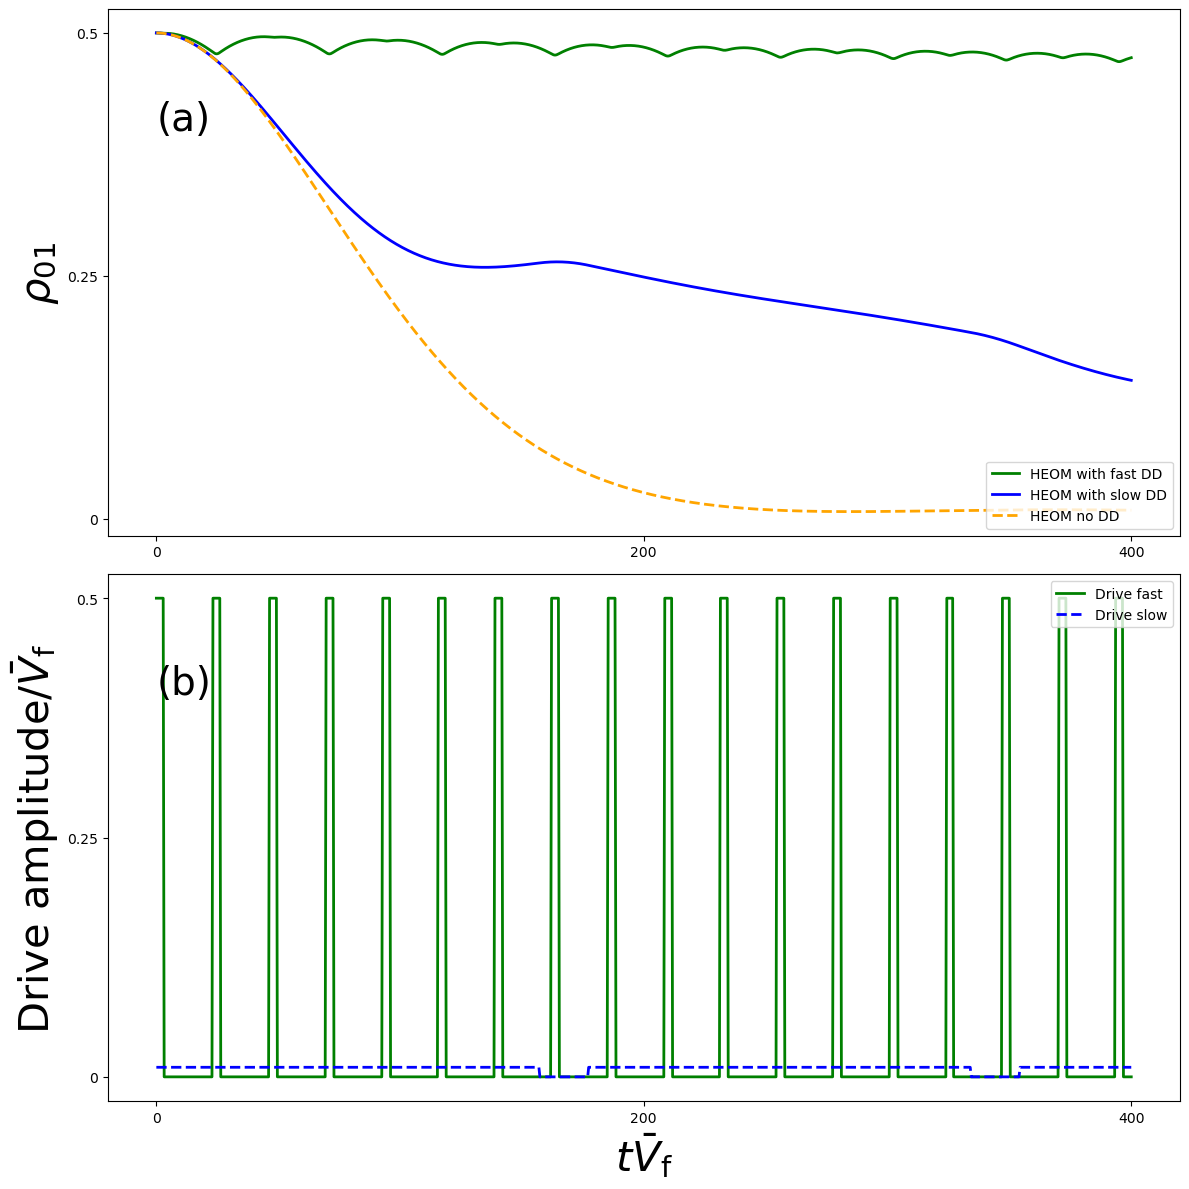

In [13]:
plot_dd_results(outputnoDD, outputDD, outputDDslow)

## Non-equally spaced pulses

Next we consider non-equally spaced pulses.

Rather than plot as a function of time we just consider the final coherence after time $T$ and 100 pulses.  We change the width of the environment to demonstate that the Uhrig sequence (i.e. the evenly spaced pulses) can be sub-optimal when the bath is very broad.

Instead of evenly spaced pulses, we will use pulses where the cummulative delay after $j$ pulses is given by:

$$
    \sin^2(\frac{\pi}{2} \frac{j}{N + 1})
$$

This is just a convenient way to describe the varying delay. We could have chosen another monotonically increasing function to represent the cummulative delay (although it might not be as effective).

In [14]:
def cummulative_delay_fractions(N):
    """ Return an array of N + 1 cummulative delay
        fractions.

        The j'th entry in the array should be the sum of
        all delays before the j'th pulse. The last entry
        should be 1 (i.e. the entire cummulative delay
        should have been used once the sequence of pulses
        is complete).

        The function should be monotonically increasing,
        strictly greater than zero and the last value
        should be 1.

        This implementation returns:

            sin((pi / 2) * (j / (N + 1)))**2

        as the cummulative delay after the j'th pulse.
    """
    return np.array([
        np.sin((np.pi / 2) * (j / (N + 1)))**2
        for j in range(0, N + 1)
    ])


def drive_opt(amplitude, avg_delay, integral, N):
    """ Return an optimized distance pulse function.

        Our previous pulses were evenly spaced. Here we
        instead use a varying delay after the j'th pulse.

        The cummulative delay is described by the function
        ``cummulative_delay_fractions`` above.
    """
    duration = integral / amplitude
    cummulative_delays = N * avg_delay * cummulative_delay_fractions(N)

    t_start = cummulative_delays + duration * np.arange(0, N + 1)
    t_end = cummulative_delays + duration * np.arange(1, N + 2)

    def pulse(t):
        if any((t_start <= t) & (t <= t_end)):
            return amplitude
        return 0.0

    return pulse

Let's plot the cummulative delays and see what they look like. Note that the cummulative delay starts at $0$, ends at $1$ and is monotonically increasing, as required.

On the same axes we plot the individual $j^{th}$ delays as a fraction of the average delay.

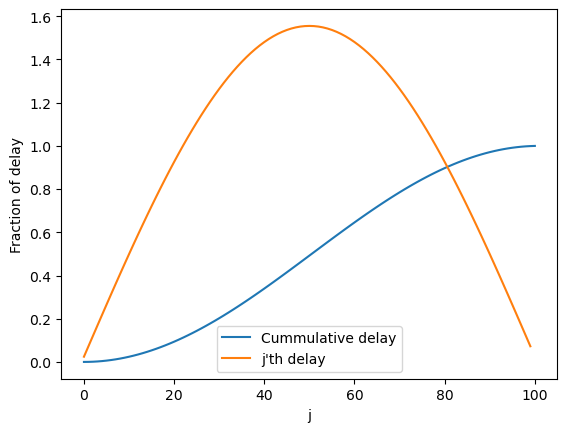

In [15]:
def plot_cummulative_delay_fractions(N):
    cummulative = cummulative_delay_fractions(N)
    individual = (cummulative[1:] - cummulative[:-1]) * N
    plt.plot(np.arange(0, N + 1), cummulative, label="Cummulative delay")
    plt.plot(np.arange(0, N), individual, label="j'th delay")
    plt.xlabel("j")
    plt.ylabel("Fraction of delay")
    plt.legend()


plot_cummulative_delay_fractions(100)

And now let us plot the first ten even and optimally spaced pulses together to compare them:

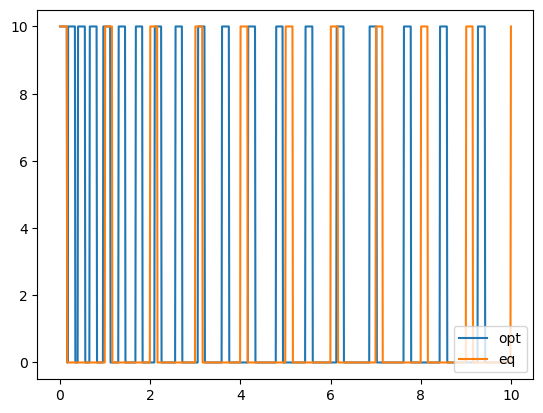

In [16]:
def plot_even_and_optimally_spaced_pulses():
    amplitude = 10.0
    integral = np.pi / 2
    duration = integral / amplitude
    delay = 1.0 - duration

    tlist = np.linspace(0, 10, 1000)

    pulse_opt = drive_opt(amplitude, delay, integral, 100)
    pulse_eq = drive(amplitude, delay, integral)

    plt.plot(
        tlist, [pulse_opt(t) for t in tlist], label="opt",
    )
    plt.plot(
        tlist, [pulse_eq(t) for t in tlist], label="eq",
    )
    plt.legend(loc=4)


plot_even_and_optimally_spaced_pulses()

Now let's simulate the effectiveness of the two sets of delays by comparing how well they maintain coherence after a hundred pulses.

We'll perform the simulation over a range of lambdas and gammas to show how the non-evenly spaced delays become optimal as the width of the bath spectral function increases.

In [17]:
# Bath parameters to simulate over:

# We use only two lambdas and two gammas so that the notebook executes
# quickly:

lams = [0.005, 0.0005]
gammas = np.linspace(0.005, 0.05, 2)

# But one can also extend the lists to larger ones:
#
# lams = [0.01, 0.005, 0.0005]
# gammas = np.linspace(0.005, 0.05, 10)

# Setup a progress bar:

progress = IntProgress(min=0, max=(2 * len(lams) * len(gammas)))
display(progress)


def simulate_100_pulses(lam, gamma, T, NC, Nk):
    """ Simulate the evolution of 100 evenly and optimally spaced pulses.

        Returns the expectation value of P12p from the final state of
        each evolution.
    """
    rho0 = (basis(2, 1) + basis(2, 0)).unit()
    rho0 = ket2dm(rho0)

    N = 100  # number of pulses to simulate
    avg_cycle_time = 1.0  # average time from one pulse to the next
    t_max = N * avg_cycle_time

    tlist = np.linspace(0, t_max, 100)

    amplitude = 10.0
    integral = np.pi / 2
    duration = integral / amplitude
    delay = avg_cycle_time - duration

    bath = DrudeLorentzPadeBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)

    # Equally spaced pulses:

    pulse_eq = drive(amplitude, delay, integral)
    H_d = QobjEvo([H_sys, [H_drive, pulse_eq]])

    hsolver = HEOMSolver(H_d, bath, NC, options=options)
    result = hsolver.run(rho0, tlist)

    P12_eq = expect(result.states[-1], P12p)
    progress.value += 1

    # Non-equally spaced pulses:

    pulse_opt = drive_opt(amplitude, delay, integral, N)
    H_d = QobjEvo([H_sys, [H_drive, pulse_opt]])

    hsolver = HEOMSolver(H_d, bath, NC, options=options)
    result = hsolver.run(rho0, tlist)

    P12_opt = expect(result.states[-1], P12p)
    progress.value += 1

    return P12_opt, P12_eq


# We use NC=2 and Nk=2 to speed up the simulation:

P12_results = [
    list(zip(*(
        simulate_100_pulses(lam=lam_, gamma=gamma_, T=0.5, NC=2, Nk=2)
        for gamma_ in gammas
    )))
    for lam_ in lams
]

IntProgress(value=0, max=8)

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.66s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.66s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.67s / Remaining 00:00:00:00

 Total run time:   0.67s


 [          1%           ] Elapsed 0.10s / Remaining 00:00:00:09

 [          2%           ] Elapsed 0.16s / Remaining 00:00:00:07

 [*         3%           ] Elapsed 0.20s / Remaining 00:00:00:06

 [*         4%           ] Elapsed 0.25s / Remaining 00:00:00:06

 [*         5%           ] Elapsed 0.30s / Remaining 00:00:00:05

 [*         6%           ] Elapsed 0.33s / Remaining 00:00:00:05

 [**        7%           ] Elapsed 0.39s / Remaining 00:00:00:05

 [**        8%           ] Elapsed 0.41s / Remaining 00:00:00:04

 [**        9%           ] Elapsed 0.44s / Remaining 00:00:00:04

 [**       10%           ] Elapsed 0.47s / Remaining 00:00:00:04

 [***      11%           ] Elapsed 0.51s / Remaining 00:00:00:04

 [***      12%           ] Elapsed 0.54s / Remaining 00:00:00:03

 [***      13%           ] Elapsed 0.58s / Remaining 00:00:00:03

 [***      14%           ] Elapsed 0.61s / Remaining 00:00:00:03

 [***      15%           ] Elapsed 0.64s / Remaining 00:00:00:03

 [****     16%           ] Elapsed 0.65s / Remaining 00:00:00:03

 [****     17%           ] Elapsed 0.68s / Remaining 00:00:00:03

 [****     18%           ] Elapsed 0.70s / Remaining 00:00:00:03

 [****     19%           ] Elapsed 0.73s / Remaining 00:00:00:03

 [*****    20%           ] Elapsed 0.76s / Remaining 00:00:00:03

 [*****    21%           ] Elapsed 0.79s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.82s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.85s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.87s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.88s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.91s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.95s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.98s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.98s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 1.01s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 1.04s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.08s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.08s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.11s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.14s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.16s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.18s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.21s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.24s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.24s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.27s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.30s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.31s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.34s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.37s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.39s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.40s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.43s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.45s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.47s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.51s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.54s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.54s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.57s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.61s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.61s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.64s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.67s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.69s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.71s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.74s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.77s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.78s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.81s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.84s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.86s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.88s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.91s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.95s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.95s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.99s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.02s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.05s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.07s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.09s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.13s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.16s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.19s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.23s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.25s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.27s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.30s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.34s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.37s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.43s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.47s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.50s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.53s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.58s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.62s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.64s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.68s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.74s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 2.77s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 2.83s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 2.89s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 2.96s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.08s / Remaining 00:00:00:00

 Total run time:   3.08s


 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.64s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.65s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.66s / Remaining 00:00:00:00

 Total run time:   0.66s


 [          1%           ] Elapsed 0.10s / Remaining 00:00:00:09

 [          2%           ] Elapsed 0.16s / Remaining 00:00:00:07

 [*         3%           ] Elapsed 0.21s / Remaining 00:00:00:06

 [*         4%           ] Elapsed 0.25s / Remaining 00:00:00:06

 [*         5%           ] Elapsed 0.31s / Remaining 00:00:00:05

 [*         6%           ] Elapsed 0.34s / Remaining 00:00:00:05

 [**        7%           ] Elapsed 0.39s / Remaining 00:00:00:05

 [**        8%           ] Elapsed 0.42s / Remaining 00:00:00:04

 [**        9%           ] Elapsed 0.44s / Remaining 00:00:00:04

 [**       10%           ] Elapsed 0.47s / Remaining 00:00:00:04

 [***      11%           ] Elapsed 0.51s / Remaining 00:00:00:04

 [***      12%           ] Elapsed 0.54s / Remaining 00:00:00:03

 [***      13%           ] Elapsed 0.58s / Remaining 00:00:00:03

 [***      14%           ] Elapsed 0.61s / Remaining 00:00:00:03

 [***      15%           ] Elapsed 0.64s / Remaining 00:00:00:03

 [****     16%           ] Elapsed 0.66s / Remaining 00:00:00:03

 [****     17%           ] Elapsed 0.69s / Remaining 00:00:00:03

 [****     18%           ] Elapsed 0.71s / Remaining 00:00:00:03

 [****     19%           ] Elapsed 0.74s / Remaining 00:00:00:03

 [*****    20%           ] Elapsed 0.77s / Remaining 00:00:00:03

 [*****    21%           ] Elapsed 0.80s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.83s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.85s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.87s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.89s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.92s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.95s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.98s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.99s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 1.02s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 1.05s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.08s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.09s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.12s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.15s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.16s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.18s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.21s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.24s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.25s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.28s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.32s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.33s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.36s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.39s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.41s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.42s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.45s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.47s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.49s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.52s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.55s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.56s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.59s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.62s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.63s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.66s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.69s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.71s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.72s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.75s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.79s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.79s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 1.82s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.86s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.87s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.89s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.92s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.95s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.96s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.99s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.02s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.06s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.08s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.09s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.13s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.16s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.19s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.23s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.25s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.26s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.30s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.33s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.36s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.40s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.46s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.51s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.54s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.57s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.61s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.65s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.68s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.71s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.76s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 2.80s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 2.85s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 2.91s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 2.99s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.10s / Remaining 00:00:00:00

 Total run time:   3.10s


 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.59s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.59s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.60s / Remaining 00:00:00:00

 Total run time:   0.60s


 [          1%           ] Elapsed 0.08s / Remaining 00:00:00:08

 [          2%           ] Elapsed 0.13s / Remaining 00:00:00:06

 [*         3%           ] Elapsed 0.18s / Remaining 00:00:00:05

 [*         4%           ] Elapsed 0.23s / Remaining 00:00:00:05

 [*         5%           ] Elapsed 0.28s / Remaining 00:00:00:05

 [*         6%           ] Elapsed 0.30s / Remaining 00:00:00:04

 [**        7%           ] Elapsed 0.35s / Remaining 00:00:00:04

 [**        8%           ] Elapsed 0.38s / Remaining 00:00:00:04

 [**        9%           ] Elapsed 0.40s / Remaining 00:00:00:04

 [**       10%           ] Elapsed 0.43s / Remaining 00:00:00:03

 [***      11%           ] Elapsed 0.46s / Remaining 00:00:00:03

 [***      12%           ] Elapsed 0.49s / Remaining 00:00:00:03

 [***      13%           ] Elapsed 0.52s / Remaining 00:00:00:03

 [***      14%           ] Elapsed 0.55s / Remaining 00:00:00:03

 [***      15%           ] Elapsed 0.58s / Remaining 00:00:00:03

 [****     16%           ] Elapsed 0.60s / Remaining 00:00:00:03

 [****     17%           ] Elapsed 0.63s / Remaining 00:00:00:03

 [****     18%           ] Elapsed 0.64s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.67s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.70s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.73s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.75s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.78s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.80s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.82s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.84s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.87s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.89s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.90s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 0.93s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 0.96s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 0.99s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 0.99s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.02s / Remaining 00:00:00:01

 [******** 35%           ] Elapsed 1.05s / Remaining 00:00:00:01

 [******** 36%           ] Elapsed 1.07s / Remaining 00:00:00:01

 [*********37%           ] Elapsed 1.08s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.11s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.14s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.14s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.17s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.19s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.20s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.23s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.26s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.27s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.29s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.32s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.33s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.35s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.38s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.40s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.41s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.43s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.46s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.47s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.50s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.52s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.54s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.56s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 1.59s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 1.62s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 1.62s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.65s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.68s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.69s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.71s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.74s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.77s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.77s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.80s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.84s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.87s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.88s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.90s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.93s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.96s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.99s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.02s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.04s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.05s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.08s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.11s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.14s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.17s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.20s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.23s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.26s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.29s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.33s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.37s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.40s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.43s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.48s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 2.51s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 2.57s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 2.66s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 2.73s / Remaining 00:00:00:00

 [********100%***********] Elapsed 2.82s / Remaining 00:00:00:00

 Total run time:   2.82s
 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.59s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.60s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.61s / Remaining 00:00:00:00

 Total run time:   0.61s


 [          1%           ] Elapsed 0.10s / Remaining 00:00:00:09

 [          2%           ] Elapsed 0.15s / Remaining 00:00:00:07

 [*         3%           ] Elapsed 0.21s / Remaining 00:00:00:06

 [*         4%           ] Elapsed 0.25s / Remaining 00:00:00:06

 [*         5%           ] Elapsed 0.31s / Remaining 00:00:00:05

 [*         6%           ] Elapsed 0.33s / Remaining 00:00:00:05

 [**        7%           ] Elapsed 0.40s / Remaining 00:00:00:05

 [**        8%           ] Elapsed 0.42s / Remaining 00:00:00:04

 [**        9%           ] Elapsed 0.45s / Remaining 00:00:00:04

 [**       10%           ] Elapsed 0.48s / Remaining 00:00:00:04

 [***      11%           ] Elapsed 0.52s / Remaining 00:00:00:04

 [***      12%           ] Elapsed 0.55s / Remaining 00:00:00:04

 [***      13%           ] Elapsed 0.59s / Remaining 00:00:00:03

 [***      14%           ] Elapsed 0.62s / Remaining 00:00:00:03

 [***      15%           ] Elapsed 0.65s / Remaining 00:00:00:03

 [****     16%           ] Elapsed 0.67s / Remaining 00:00:00:03

 [****     17%           ] Elapsed 0.70s / Remaining 00:00:00:03

 [****     18%           ] Elapsed 0.72s / Remaining 00:00:00:03

 [****     19%           ] Elapsed 0.75s / Remaining 00:00:00:03

 [*****    20%           ] Elapsed 0.78s / Remaining 00:00:00:03

 [*****    21%           ] Elapsed 0.81s / Remaining 00:00:00:03

 [*****    22%           ] Elapsed 0.84s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.87s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.88s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.90s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.93s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.96s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.99s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 0.99s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 1.02s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 1.05s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.08s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.09s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.11s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.14s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.15s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.17s / Remaining 00:00:00:01

 [*********38%           ] Elapsed 1.20s / Remaining 00:00:00:01

 [*********39%           ] Elapsed 1.22s / Remaining 00:00:00:01

 [*********40%           ] Elapsed 1.23s / Remaining 00:00:00:01

 [*********41%           ] Elapsed 1.26s / Remaining 00:00:00:01

 [*********42%           ] Elapsed 1.28s / Remaining 00:00:00:01

 [*********43%           ] Elapsed 1.29s / Remaining 00:00:00:01

 [*********44%           ] Elapsed 1.31s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.34s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.36s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.38s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.40s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.42s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.44s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.47s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.49s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.50s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.53s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 1.55s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 1.56s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 1.59s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 1.62s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 1.63s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 1.65s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 1.68s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 1.71s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 1.71s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 1.74s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 1.77s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 1.78s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 1.80s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 1.83s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.86s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.86s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.89s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.92s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.95s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.96s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.98s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.01s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.03s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.06s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.09s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.11s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.12s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 2.15s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 2.18s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 2.20s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 2.23s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 2.25s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 2.28s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 2.31s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 2.34s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 2.39s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 2.43s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 2.46s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 2.48s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 2.53s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 2.56s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 2.61s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 2.67s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 2.73s / Remaining 00:00:00:00

 [********100%***********] Elapsed 2.82s / Remaining 00:00:00:00

 Total run time:   2.82s


Now that we have the expectation values of $\rho_{01}$ let's plot them as a function of gamma for each lambda. Note how in each case the non-evenly spaced pulses become optimal once gamma is sufficiently small:

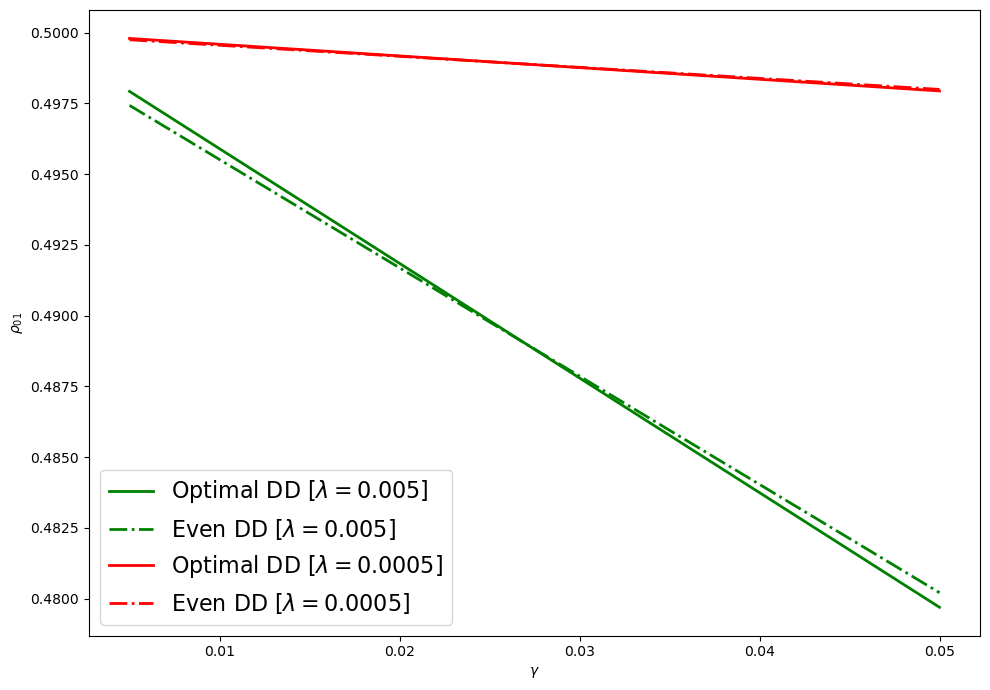

In [18]:
fig, axes = plt.subplots(1, 1, sharex=False, figsize=(10, 7))
colors = ["green", "red", "blue"]

for i in range(len(lams)):
    color = colors[i % len(colors)]
    axes.plot(
        gammas, np.real(P12_results[i][0]),
        color, linestyle='-', linewidth=2,
        label=f"Optimal DD [$\\lambda={lams[i]}$]",
    )
    axes.plot(
        gammas, np.real(P12_results[i][1]),
        color, linestyle='-.', linewidth=2,
        label=f"Even DD [$\\lambda={lams[i]}$]",
    )

axes.set_ylabel(r"$\rho_{01}$")
axes.set_xlabel(r"$\gamma$")
axes.legend(fontsize=16)

fig.tight_layout();

And now you know about dynamically decoupling a qubit from its environment!

## About

In [19]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.2.0.dev0+4033695
Numpy Version:      2.2.4
Scipy Version:      1.15.2
Cython Version:     3.0.12
Matplotlib Version: 3.10.1
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          Generic
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------



qutip-jax: 0.1.1.dev5
qutip-qtrl: 0.2.0.dev0+acb71a0
qutip-qip: 0.5.0.dev0+d58a82d

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


## Testing

This section can include some tests to verify that the expected outputs are generated within the notebook. We put this section at the end of the notebook, so it's not interfering with the user experience. Please, define the tests using assert, so that the cell execution fails if a wrong output is generated.

In [20]:
assert 1 == 1